## Case 2 : Pre-trained word_embed + Dense <br> <small>when available data is significantly little</small>

### Import data

In [1]:
from keras.datasets import imdb

max_features = 10000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

Using TensorFlow backend.


### Pad X into maxlen

In [2]:
from keras import preprocessing

maxlen = 100

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

### Build model

In [49]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics

max_features=10000
embedding_dim=100
maxlen=100

def generate_embedding_matrix():
    embeddings_index = {}
    f = open('./glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    word_index = imdb.get_word_index()
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        if i < max_features:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

def build_model(pre_train=False, embedding_matrix=None):
    if pre_train and embedding_matrix is None:
        raise Exception('Please provide embedding_matrix for pre_train use case')
    
    model = models.Sequential()
    model.add(layers.Embedding(input_dim=max_features, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))
    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    if pre_train:
        model.layers[0].set_weights([embedding_matrix])
        model.layers[0].trainable = False
    
    
    model.compile(optimizer=optimizers.RMSprop(lr=1e-3), 
                  loss=losses.binary_crossentropy, 
                  metrics=[metrics.binary_accuracy])
    return model

### K-fold cross-validate

In [53]:
import numpy as np

k = 4
num_val_samples = len(x_train) // k
batch_size = 32
num_epochs = 20
embedding_matrix = generate_embedding_matrix()

self_train_acc_histories = []
pre_train_acc_histories = []
self_train_loss_histories = []
pre_train_loss_histories = []

for i in range(k):        
    x_val = x_train[i * num_val_samples : (i+1) * num_val_samples]
    y_val = y_train[i * num_val_samples : (i+1) * num_val_samples]
    
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples], 
         x_train[(i+1) * num_val_samples:]], 
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples], 
         y_train[(i+1) * num_val_samples:]], 
        axis=0)
    
    # Trim available train data to simuate the lack of data situation
    indices = np.arange(partial_x_train.shape[0])
    np.random.shuffle(indices)
    partial_x_train = partial_x_train[indices]
    partial_y_train = partial_y_train[indices]
    partial_x_train = partial_x_train[:int(len(partial_x_train) * 0.01)]
    partial_y_train = partial_y_train[:int(len(partial_y_train) * 0.01)]
    
    for j in range(2):
        if j == 0:
            model = build_model()
        else:
            model = build_model(True, embedding_matrix)
    
        history = model.fit(partial_x_train, 
                            partial_y_train, 
                            batch_size=batch_size, 
                            epochs=num_epochs, 
                            verbose=0,
                            validation_data=(x_val, y_val))    
        val_binary_accuracy = history.history['val_binary_accuracy']        
        val_loss = history.history['val_loss']
        if j == 0:
            self_train_acc_histories.append(val_binary_accuracy)
            self_train_loss_histories.append(val_loss)
        else:
            pre_train_acc_histories.append(val_binary_accuracy)
            pre_train_loss_histories.append(val_loss)

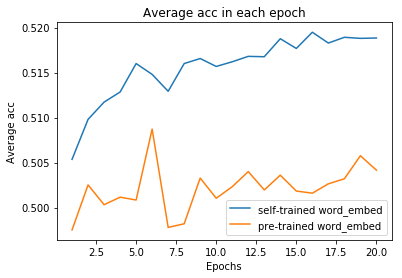

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

averages_acc_self = np.mean(np.array(self_train_acc_histories), axis=0)
averages_acc_pre = np.mean(np.array(pre_train_acc_histories), axis=0)

plt.plot(range(1, len(averages_histories_self) + 1), averages_acc_self, label='self-trained word_embed')
plt.plot(range(1, len(averages_histories_pre) + 1), averages_acc_pre, label='pre-trained word_embed')
plt.title('Average acc in each epoch')
plt.xlabel('Epochs')
plt.ylabel('Average acc')
plt.legend()
plt.show()

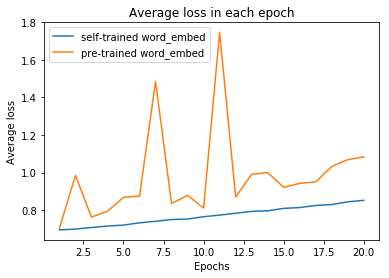

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

averages_loss_self = np.mean(np.array(self_train_loss_histories), axis=0)
averages_loss_pre = np.mean(np.array(pre_train_loss_histories), axis=0)

plt.plot(range(1, len(averages_loss_self) + 1), averages_loss_self, label='self-trained word_embed')
plt.plot(range(1, len(averages_loss_pre) + 1), averages_loss_pre, label='pre-trained word_embed')
plt.title('Average loss in each epoch')
plt.xlabel('Epochs')
plt.ylabel('Average loss')
plt.legend()
plt.show()